In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")


## Importing Data

In [2]:
movie_df = pd.read_csv("data/movies_metadata.csv")

movie_keywords_df = pd.read_csv("data/keywords.csv")

movie_credits_df = pd.read_csv("data/credits.csv")

movie_ratings_df = pd.read_csv("data/ratings_small.csv")

links_df = pd.read_csv('data/links_small.csv')

## EDA

#### Fixing null values

In [3]:
print("TOTAL:",len(movie_df))
movie_df.isna().sum()

TOTAL: 45466


adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

1. Drop Columns: belongs_to_collection, homepage, tagline (too many missing values wrt total data)
2. Drop Null Rows: imdb_id, overview, poster_path, production_companies, production_countries, release_date, spoken_languages, status, title, video, vote_count
2. Impute with mean: revenue, vote_average
4. Impute with mode: runtime


In [4]:
import pandas as pd

# 1. Drop Columns
movie_df.drop(columns=['belongs_to_collection', 'homepage', 'tagline'], inplace=True)

# 2. Drop Null Rows
cols_to_drop_null = ['imdb_id', 'overview', 'poster_path', 'production_companies', 
                     'production_countries', 'release_date', 'spoken_languages', 
                     'status', 'title', 'video', 'vote_count']
movie_df.dropna(subset=cols_to_drop_null, inplace=True)

# 3. Impute with mean
cols_to_impute_mean = ['revenue', 'vote_average']
for col in cols_to_impute_mean:
    mean_value = movie_df[col].mean()
    movie_df[col].fillna(mean_value, inplace=True)

# 4. Impute with mode
cols_to_impute_mode = ['runtime']
for col in cols_to_impute_mode:
    mode_value = movie_df[col].mode()[0]
    movie_df[col].fillna(mode_value, inplace=True)


In [5]:
movie_df.isna().sum()

adult                    0
budget                   0
genres                   0
id                       0
imdb_id                  0
original_language       10
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
status                   0
title                    0
video                    0
vote_average             0
vote_count               0
dtype: int64

In [6]:
movie_ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

#### Checking datatypes

In [7]:
movie_df.dtypes

adult                    object
budget                   object
genres                   object
id                       object
imdb_id                  object
original_language        object
original_title           object
overview                 object
popularity               object
poster_path              object
production_companies     object
production_countries     object
release_date             object
revenue                 float64
runtime                 float64
spoken_languages         object
status                   object
title                    object
video                    object
vote_average            float64
vote_count              float64
dtype: object

In [8]:
# Convert columns to appropriate data types
movie_df['adult'] = movie_df['adult'].astype('bool')
movie_df['budget'] = pd.to_numeric(movie_df['budget'], errors='coerce')
movie_df['genres'] = movie_df['genres'].astype('str')
movie_df['id'] = pd.to_numeric(movie_df['id'], errors='coerce')
movie_df['imdb_id'] = movie_df['imdb_id'].astype('str')
movie_df['original_language'] = movie_df['original_language'].astype('str')
movie_df['original_title'] = movie_df['original_title'].astype('str')
movie_df['overview'] = movie_df['overview'].astype('str')
movie_df['popularity'] = pd.to_numeric(movie_df['popularity'], errors='coerce')
movie_df['poster_path'] = movie_df['poster_path'].astype('str')
movie_df['production_companies'] = movie_df['production_companies'].astype('str')
movie_df['production_countries'] = movie_df['production_countries'].astype('str')
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'], errors='coerce')
movie_df['spoken_languages'] = movie_df['spoken_languages'].astype('str')
movie_df['status'] = movie_df['status'].astype('str')
movie_df['title'] = movie_df['title'].astype('str')
movie_df['video'] = movie_df['video'].astype('bool')
movie_df['vote_average'] = pd.to_numeric(movie_df['vote_average'], errors='coerce')
movie_df['vote_count'] = pd.to_numeric(movie_df['vote_count'], errors='coerce')


In [9]:
movie_df.dtypes

adult                             bool
budget                           int64
genres                          object
id                               int64
imdb_id                         object
original_language               object
original_title                  object
overview                        object
popularity                     float64
poster_path                     object
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                        float64
runtime                        float64
spoken_languages                object
status                          object
title                           object
video                             bool
vote_average                   float64
vote_count                     float64
dtype: object

In [10]:
movie_ratings_df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

#### Removing lower votecount data

In [11]:
quantile_value = 0.75
threshold_vote_count = movie_df['vote_count'].quantile(quantile_value)
print(threshold_vote_count)
movie_df = movie_df[movie_df['vote_count'] >= threshold_vote_count]


36.0


In [12]:
movie_df

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,True,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,True,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0
2,True,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0
4,True,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0
5,True,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,False,7.7,1886.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45348,True,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",44918,tt1640571,en,Titanic II,On the 100th anniversary of the original voyag...,4.359886,/tUSMxX60DGkTIoiDnUNNrJLtP3t.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-08-07,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Titanic 2,False,3.4,55.0
45373,True,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",426272,tt6598626,en,Take Me,Ray is a fledgling entrepreneur who specialize...,9.222308,/70kL9vXjbCAYd3wNXYScCBGlkJC.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2017-05-05,0.0,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Take Me,False,6.0,38.0
45380,True,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",432789,tt5990342,en,The Incredible Jessica James,"Burned by a bad breakup, a struggling New York...",5.667067,/r7tDHGsFzHY0YBCaaNctvAxZhpc.jpg,...,[],2017-01-27,0.0,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Incredible Jessica James,False,6.2,37.0
45437,True,0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",455661,tt6969946,en,In a Heartbeat,A closeted boy runs the risk of being outed by...,20.821780,/wJUJROdLOtOzMixkjkx1aaZGSLl.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2017-06-01,0.0,4.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,In a Heartbeat,False,8.3,146.0


#### Linking IMDB ID and finding TMDB Ids to be able to work with Ratings dataset

In [13]:
links_df.dropna(inplace=True)
links_df = links_df.astype(int)


In [14]:
movie_df['imdb_id'] = movie_df['imdb_id'].str.replace('tt', '')
movie_df['imdb_id'] = movie_df['imdb_id'].astype(int)

In [15]:
movie_df = pd.merge(movie_df, links_df, left_on='imdb_id', right_on='imdbId', how='left').dropna()#.isna().sum()
# len(set(movie_df['id'])),len(set(links_df['movieId']))

In [16]:
movie_df['movieId'] = movie_df['movieId'].astype(int)
common_movie_ids = set(movie_df['movieId']).intersection(set(movie_ratings_df['movieId']))
print(len(common_movie_ids))

6375


In [17]:
len(set(movie_df['movieId'])), len(set(movie_ratings_df['movieId']))

(6408, 9066)

In [18]:
movie_df.drop(['imdbId','tmdbId'],axis=1,inplace=True)


In [19]:
movie_df = movie_df[movie_df['movieId'].isin(common_movie_ids)]
movie_ratings_df = movie_ratings_df[movie_ratings_df['movieId'].isin(common_movie_ids)]

### Merging DF

In [20]:
df = pd.merge(movie_df, movie_keywords_df, on='id', how='left')
df.reset_index(inplace=True, drop=True)

In [21]:
df = pd.merge(df, movie_credits_df, on='id', how='left')
df.reset_index(inplace=True, drop=True)

In [22]:
df.head(5)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,spoken_languages,status,title,video,vote_average,vote_count,movieId,keywords,cast,crew
0,True,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0,1,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,True,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0,2,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,True,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0,3,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,True,0,"[{'id': 35, 'name': 'Comedy'}]",11862,113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0,5,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
4,True,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,False,7.7,1886.0,6,"[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."


In [23]:
df.drop(['id'],axis=1,inplace=True)

### Cleaning JSON type columns

In [24]:
json_columns_to_extract_name = ['genres','keywords','cast','crew','production_companies']
for column in json_columns_to_extract_name:
    df[column] = df[column].apply(lambda x: [i['name'].lower() for i in eval(x)])
    df[column] = df[column].apply(lambda x: ', '.join([i.replace(" ","") for i in x]))
    

In [25]:
df.head(5)

,adult,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,spoken_languages,status,title,video,vote_average,vote_count,movieId,keywords,cast,crew
0,True,30000000,"animation, comedy, family",114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,pixaranimationstudios,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0,1,"jealousy, toy, boy, friendship, friends, rival...","tomhanks, timallen, donrickles, jimvarney, wal...","johnlasseter, josswhedon, andrewstanton, joelc..."
1,True,65000000,"adventure, fantasy, family",113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"tristarpictures, teitlerfilm, interscopecommun...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0,2,"boardgame, disappearance, basedonchildren'sboo...","robinwilliams, jonathanhyde, kirstendunst, bra...","larryj.franco, jonathanhensleigh, jameshorner,..."
2,True,0,"romance, comedy",113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"warnerbros., lancastergate",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0,3,"fishing, bestfriend, duringcreditsstinger, oldmen","waltermatthau, jacklemmon, ann-margret, sophia...","howarddeutch, markstevenjohnson, markstevenjoh..."
3,True,0,comedy,113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"sandollarproductions, touchstonepictures",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0,5,"baby, midlifecrisis, confidence, aging, daught...","stevemartin, dianekeaton, martinshort, kimberl...","alansilvestri, elliotdavis, nancymeyers, nancy..."
4,True,60000000,"action, crime, drama, thriller",113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"regencyenterprises, forwardpass, warnerbros.",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,False,7.7,1886.0,6,"robbery, detective, bank, obsession, chase, sh...","alpacino, robertdeniro, valkilmer, jonvoight, ...","michaelmann, michaelmann, artlinson, michaelma..."


### Train Test Split

In [26]:
movie_ratings_df = movie_ratings_df#[movie_ratings_df['userId']==547][:100]

In [27]:
user_ratings = defaultdict(list)
for _, row in movie_ratings_df.iterrows():
    user_ratings[row['userId']].append((row['userId'], row['movieId'], row['timestamp'], row['rating']))

train_ratio = 0.8
train_ratings = []
test_ratings = []
for user_id, ratings in user_ratings.items():
    n_ratings = len(ratings)
    n_train = int(train_ratio * n_ratings)
    train_ratings.extend(ratings[:n_train])
    test_ratings.extend(ratings[n_train:])

train_user_df = pd.DataFrame(train_ratings, columns=['userId', 'movieId', 'timestamp', 'rating'])
test_user_df = pd.DataFrame(test_ratings, columns=['userId', 'movieId', 'timestamp', 'rating'])

# Shuffle Train/Test DataFrames
train_user_df = train_user_df.sample(frac=1).reset_index(drop=True)
test_user_df = test_user_df.sample(frac=1).reset_index(drop=True)


In [28]:
train_user_df

,userId,movieId,timestamp,rating
0,607.0,3977.0,1.118248e+09,4.0
1,125.0,1682.0,1.244538e+09,5.0
2,311.0,944.0,8.980086e+08,2.0
3,94.0,733.0,1.291780e+09,2.5
4,452.0,4155.0,1.151812e+09,1.0
...,...,...,...,...
75024,263.0,541.0,1.117843e+09,3.5
75025,531.0,364.0,1.240402e+09,4.0
75026,433.0,6957.0,1.417930e+09,3.0
75027,295.0,2324.0,1.112546e+09,4.0


### Feature Selection

In [29]:
df.columns

Index(['adult', 'budget', 'genres', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'video',
       'vote_average', 'vote_count', 'movieId', 'keywords', 'cast', 'crew'],
      dtype='object')

In [30]:
df.head(5)

,adult,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,spoken_languages,status,title,video,vote_average,vote_count,movieId,keywords,cast,crew
0,True,30000000,"animation, comedy, family",114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,pixaranimationstudios,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0,1,"jealousy, toy, boy, friendship, friends, rival...","tomhanks, timallen, donrickles, jimvarney, wal...","johnlasseter, josswhedon, andrewstanton, joelc..."
1,True,65000000,"adventure, fantasy, family",113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"tristarpictures, teitlerfilm, interscopecommun...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0,2,"boardgame, disappearance, basedonchildren'sboo...","robinwilliams, jonathanhyde, kirstendunst, bra...","larryj.franco, jonathanhensleigh, jameshorner,..."
2,True,0,"romance, comedy",113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"warnerbros., lancastergate",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0,3,"fishing, bestfriend, duringcreditsstinger, oldmen","waltermatthau, jacklemmon, ann-margret, sophia...","howarddeutch, markstevenjohnson, markstevenjoh..."
3,True,0,comedy,113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"sandollarproductions, touchstonepictures",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0,5,"baby, midlifecrisis, confidence, aging, daught...","stevemartin, dianekeaton, martinshort, kimberl...","alansilvestri, elliotdavis, nancymeyers, nancy..."
4,True,60000000,"action, crime, drama, thriller",113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"regencyenterprises, forwardpass, warnerbros.",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,False,7.7,1886.0,6,"robbery, detective, bank, obsession, chase, sh...","alpacino, robertdeniro, valkilmer, jonvoight, ...","michaelmann, michaelmann, artlinson, michaelma..."


In [31]:
selected_features = ['adult', 'budget', 'genres','original_language', 'overview', 'popularity',
       'production_companies', 'release_date',
       'revenue', 'runtime', 'spoken_languages',
       'vote_average', 'vote_count', 'keywords','movieId']
df = df[selected_features]


In [32]:
# Will help if we differentiate this for the NN in the future
numerical_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_count',]#'vote_average']
text_features = ['overview']
categorical_features = ['genres', 'original_language', 'production_companies', 'spoken_languages', 'keywords']
multi_valued_columns = ['genres', 'production_companies', 'keywords','spoken_languages']


In [33]:
# Preprocess numerical columns
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Preprocess categorical columns
categorical_columns = ['original_language']
df = pd.get_dummies(df, columns=categorical_columns)

 
# Preprocess multi-valued columns (e.g., genres)

# Function to split and encode multi-valued columns
def process_multi_valued_column(column):
    unique_values = set()
    for val in df[column].dropna():
        unique_values.update(val.split(', '))
    value_to_index = {value: index for index, value in enumerate(unique_values)}
    encoded_data = []
    for val in df[column]:
        if pd.isna(val):
            encoded_data.append([])
        else:
            encoded_data.append([value_to_index[value] for value in val.split(', ')])
    return encoded_data, len(unique_values)

# Process each multi-valued column
encoded_multi_valued_data = {}
for column in multi_valued_columns:
    encoded_data, num_unique_values = process_multi_valued_column(column)
    encoded_multi_valued_data[column] = encoded_data

# Concatenate all preprocessed data
processed_data = df[['movieId','budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count'] +
                    list(df.filter(regex='^original_language_|^status_|^video_'))]

for column, encoded_data in encoded_multi_valued_data.items():
    max_num_values = max(np.hstack(encoded_data))
    for i in range(max_num_values+1):
        processed_data[column + f'_{i}'] = [1 if i < len(values) else 0 for values in encoded_data]

print(processed_data.head())

   movieId    budget  popularity   revenue   runtime  vote_average  \
0        1  0.180400    1.212996  2.011808 -1.006205           7.7   
1        2  1.102132    0.739605  1.279006 -0.136392           6.9   
2        3 -0.609655    0.230578 -0.459743 -0.249846           6.5   
3        5 -0.609655   -0.088642  0.046927 -0.060756           5.7   
4        6  0.970456    0.826902  0.780398  2.359595           7.7   

   vote_count  original_language_af  original_language_ar  \
0    4.198681                     0                     0   
1    1.571526                     0                     0   
2   -0.459662                     0                     0   
3   -0.388776                     0                     0   
4    1.110330                     0                     0   

   original_language_bn  ...  spoken_languages_246  spoken_languages_247  \
0                     0  ...                     0                     0   
1                     0  ...                     0          

In [34]:
# columns_arr = []
# done_columns = set()
# for column in processed_data.columns:
#     col_name = column.split("_")[0]
#     if col_name not in done_columns:
#         columns_arr.append(col_name)
#         done_columns.add(col_name)
# print(columns_arr)
# processed_data[[col for col in processed_data.columns  if 'genres' in col]]#.iloc[0]
# a = set()
# for i in df['spoken_languages']:
#     for j in i.split(', '):
#         a.add(j)
# print(len(a))

## Two Tower Neural Network
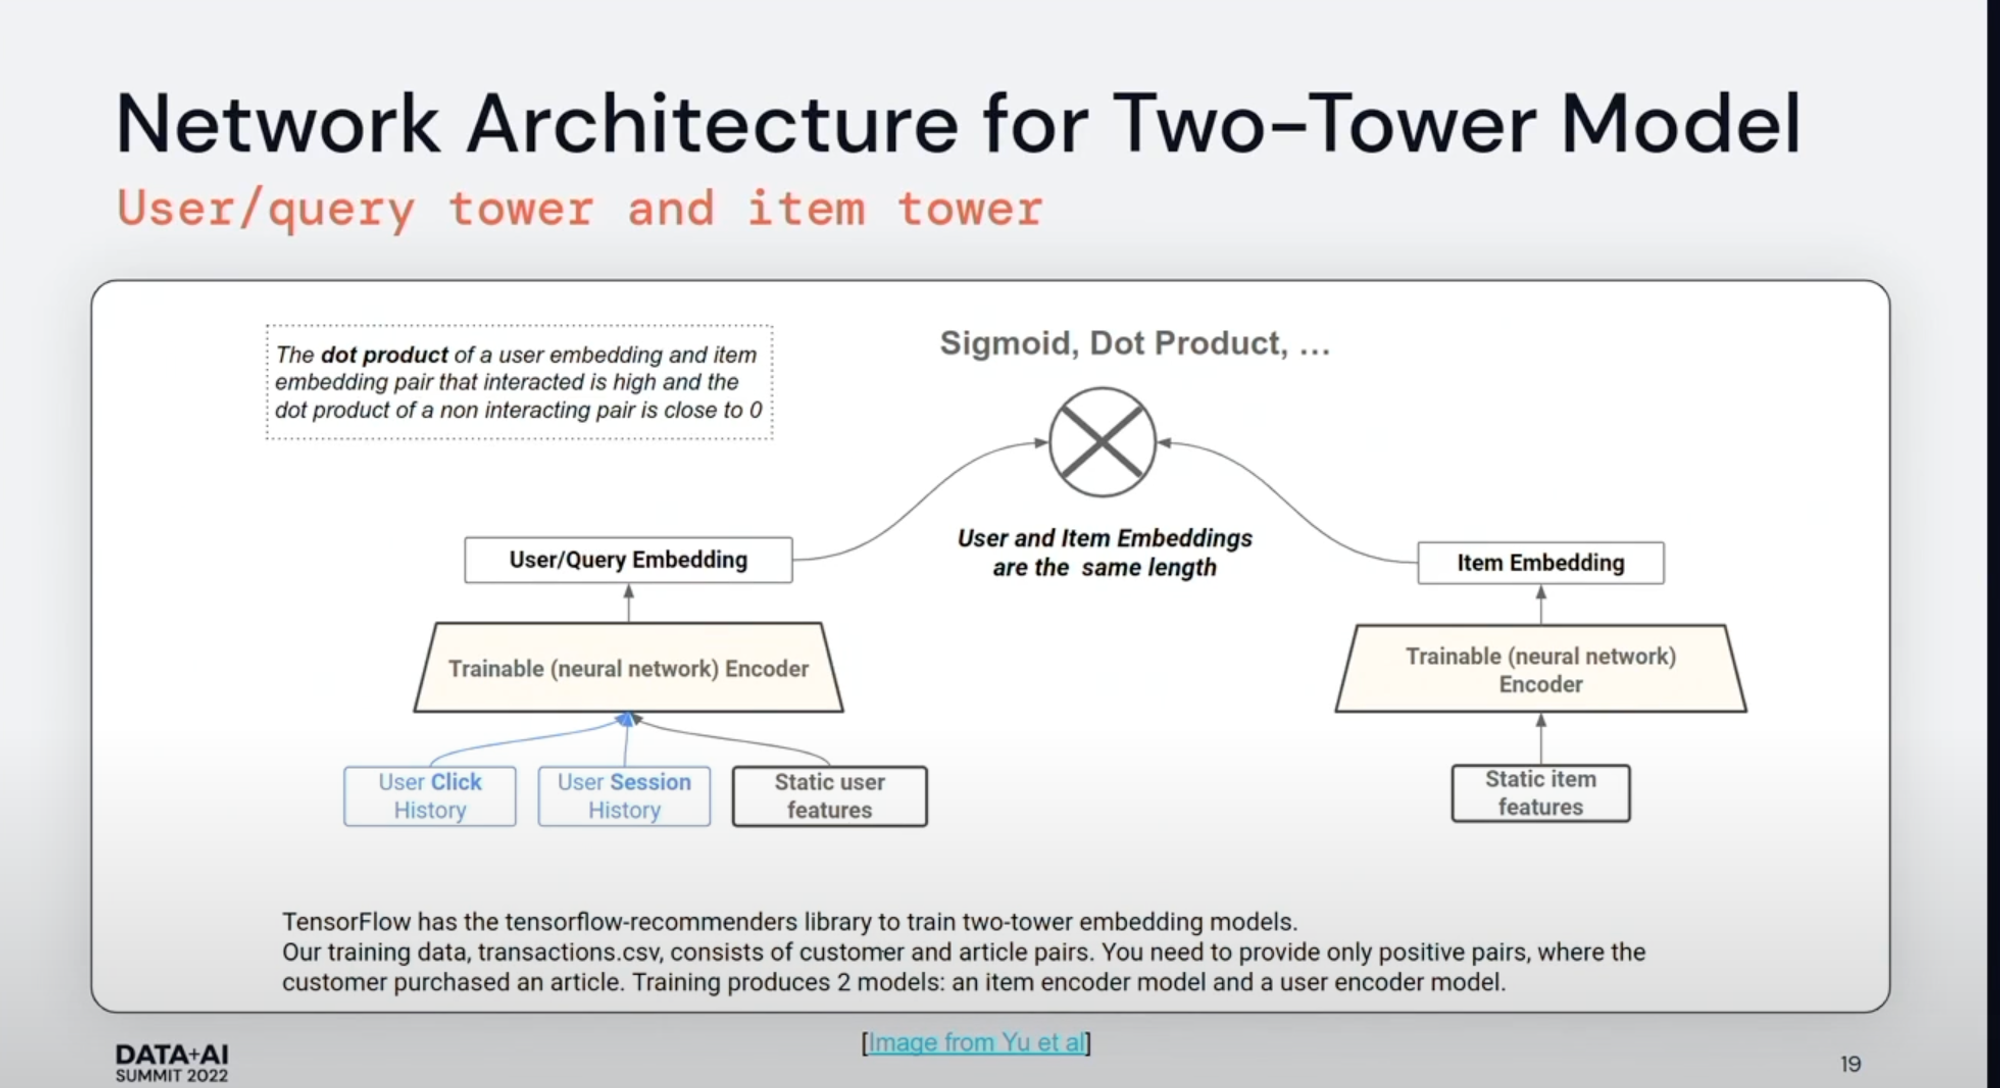

In [35]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

### Dataset

In [36]:
class RecommendationDataset(Dataset):
    def __init__(self, user_df, item_df, threshold=3.5):
        self.user_df = user_df
        self.user_df['user_liked'] = self.user_df['rating']>=3.5
        self.item_df = item_df

    def __len__(self):
        return len(self.user_df)

    def __getitem__(self, idx):
        user = self.user_df.iloc[idx].drop('user_liked')
        movie = self.item_df[self.item_df['movieId']==user['movieId']].iloc[0]
        label = self.user_df.iloc[idx]['user_liked']
        rating = self.user_df.iloc[idx]['rating']
        return {'user':np.array(user), 'movie':np.array(movie), 'label':label, 'rating': rating}

In [37]:
dataset = RecommendationDataset(train_user_df, processed_data)
test_dataset = RecommendationDataset(test_user_df, processed_data)
print(len(dataset),len(test_dataset))

75029 19070


In [38]:
dataset[0]

{'user': array([607.0, 3977.0, 1118247755.0, 4.0], dtype=object),
 'movie': array([3.97700000e+03, 1.81318132e+00, 4.45475297e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'label': True,
 'rating': 4.0}

In [39]:
test_dataset[0]

{'user': array([380.0, 96737.0, 1357606293.0, 3.5], dtype=object),
 'movie': array([9.67370000e+04, 7.07103875e-01, 2.72767781e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'label': True,
 'rating': 3.5}

### Dataloader

In [40]:
def custom_collate_fn(batch):
    batch_users = []
    batch_movies = []
    batch_labels = []
    batch_ratings = []
    for sample in batch:
        batch_users.append(sample['user'])
        batch_movies.append(sample['movie'])
        batch_labels.append(sample['label'])
        batch_ratings.append(sample['rating'])
    batch_users = torch.tensor(batch_users, dtype=torch.float)
    batch_movies = torch.tensor(batch_movies, dtype=torch.float)
    batch_labels = torch.tensor(batch_labels, dtype=torch.float)
    batch_ratings = torch.tensor(batch_ratings, dtype=torch.float)
    return {'user': batch_users, 'movie': batch_movies, 'label': batch_labels, 'rating': batch_ratings}

In [41]:
# Data loader
batch_size = 64

recommendation_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn = custom_collate_fn)
test_recommendation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn = custom_collate_fn)


### Model

In [42]:
# Model
class TransformerTower(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_layers=2, num_heads=4):
        super(TransformerTower, self).__init__()
        self.embedding = nn.Linear(num_embeddings, embedding_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads, dim_feedforward=2048),
            num_layers
        )

    def forward(self, x):
        embedded = self.embedding(x)
        output = self.transformer(embedded)
        return output

In [43]:
class TwoTowerModel(nn.Module):
    def __init__(self, user_vector_length, movie_vector_length, embedding_dim):
        super(TwoTowerModel, self).__init__()
        self.user_embedding = nn.Sequential(
            nn.Linear(user_vector_length, 100),
            nn.ReLU(),
            nn.Linear(100, embedding_dim), 
            nn.ReLU(),
        )
        self.movie_embedding = nn.Sequential(
            nn.Linear(movie_vector_length, embedding_dim*2),
            nn.ReLU(),
            nn.Linear(embedding_dim*2, embedding_dim), 
            nn.ReLU(),
        )
    
    def forward(self, user, movie):
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        return user_embedded, movie_embedded


In [44]:
# Training/Loss/Evaluation with NDCG 
user_vector_length = dataset[0]['user'].shape[0]
movie_vector_length = dataset[0]['movie'].shape[0]
embedding_size = 768
model = TwoTowerModel(user_vector_length, movie_vector_length, embedding_size)


### Optimizer & Parameters

In [45]:
lr = 0.001
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


### Loss function

In [46]:
def cosine_similarity_loss(user_embedding, movie_embedding, user_liked):
    user_embedding_normalized = torch.nn.functional.normalize(user_embedding, p=2, dim=-1)
    movie_embedding_normalized = torch.nn.functional.normalize(movie_embedding, p=2, dim=-1)
    cosine_similarities = torch.nn.functional.cosine_similarity(user_embedding_normalized, movie_embedding_normalized, dim=-1)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(cosine_similarities, user_liked.float())
    return loss


### Training

In [47]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(model, train_dataloader, val_dataloader, num_epochs, optimizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        total_accuracy = 0.0

        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, batch in progress_bar:
            user = batch['user']
            items = batch['movie'] 
            labels = batch['label']
            user = user.to(device)
            items = items.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            user_embed, item_embed = model(user, items)

            # Compute cosine similarity
            cosine_similarity = F.cosine_similarity(user_embed, item_embed)

            # Compute cosine similarity loss based on label
            target_similarity = labels.float()  # If label is 1, target similarity is 1, else it's 0
            cosine_similarity_loss = F.mse_loss(cosine_similarity, target_similarity)

            # Backward pass and optimization
            cosine_similarity_loss.backward()
            optimizer.step()

            total_loss += cosine_similarity_loss.item()

            if (i + 1) % 100 == 0:
                progress_bar.set_description(f"Epoch {epoch + 1}, Step {i + 1}, Loss: {total_loss / (i + 1):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                user = batch['user']
                items = batch['movie'] 
                labels = batch['label']
                user = user.to(device)
                items = items.to(device)

                user_embed, item_embed = model(user, items)

                val_loss += F.mse_loss(F.cosine_similarity(user_embed, item_embed), labels.float()).item()

        val_loss /= len(val_dataloader)

        print(f"Epoch {epoch + 1}, Train Loss: {total_loss / len(train_dataloader):.4f}, Val Loss: {val_loss:.4f}")

    print("Training finished.")


In [48]:
train_model(model, recommendation_dataloader, test_recommendation_dataloader, num_epochs, optimizer)

Epoch 1, Step 1100, Loss: 0.2340: 100%|█████| 1173/1173 [20:11<00:00,  1.03s/it]


Epoch 1, Train Loss: 0.2336, Val Loss: 0.2332


Epoch 2, Step 1100, Loss: 0.2266: 100%|█████| 1173/1173 [19:54<00:00,  1.02s/it]


Epoch 2, Train Loss: 0.2265, Val Loss: 0.2307


Epoch 3, Step 1100, Loss: 0.2226: 100%|█████| 1173/1173 [20:36<00:00,  1.05s/it]


Epoch 3, Train Loss: 0.2226, Val Loss: 0.2269


Epoch 4, Step 1100, Loss: 0.2207: 100%|█████| 1173/1173 [36:04<00:00,  1.84s/it]


Epoch 4, Train Loss: 0.2207, Val Loss: 0.2282


Epoch 5, Step 1100, Loss: 0.2193: 100%|█████| 1173/1173 [17:03<00:00,  1.15it/s]


Epoch 5, Train Loss: 0.2191, Val Loss: 0.2280


Epoch 6, Step 1100, Loss: 0.2182: 100%|█████| 1173/1173 [17:04<00:00,  1.15it/s]


Epoch 6, Train Loss: 0.2181, Val Loss: 0.2381


Epoch 7, Step 1100, Loss: 0.2178: 100%|█████| 1173/1173 [17:08<00:00,  1.14it/s]


Epoch 7, Train Loss: 0.2177, Val Loss: 0.2338


Epoch 8, Step 1100, Loss: 0.2176: 100%|█████| 1173/1173 [17:04<00:00,  1.15it/s]


Epoch 8, Train Loss: 0.2175, Val Loss: 0.2247


Epoch 9, Step 1100, Loss: 0.2165: 100%|█████| 1173/1173 [17:01<00:00,  1.15it/s]


Epoch 9, Train Loss: 0.2164, Val Loss: 0.2305


Epoch 10, Step 1100, Loss: 0.2157: 100%|████| 1173/1173 [17:10<00:00,  1.14it/s]


Epoch 10, Train Loss: 0.2158, Val Loss: 0.2252
Training finished.


In [49]:
for val_datapoint in tqdm(test_recommendation_dataloader, desc='Validation'):
    user_val = val_datapoint['user']
    movie_val = val_datapoint['movie']
    user_liked_val = val_datapoint['label']

    user_embedding_val, movie_embedding_val = model(user_val, movie_val)
    print(val_datapoint.keys())
    break

Validation:   0%|                                       | 0/298 [00:00<?, ?it/s]

dict_keys(['user', 'movie', 'label', 'rating'])


In [50]:
idx=4
F.cosine_similarity(user_embedding_val, movie_embedding_val)[idx]

tensor(0.6675, grad_fn=<SelectBackward0>)

In [57]:
checkpoint_path = 'final_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_path)

## Calculating NDCG Score

In [54]:
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score


def evaluate_model(model, val_dataloader, k=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    similarities = []
    user_ids = []
    movie_ids = []
    ratings = []

    with torch.no_grad():
        for batch in val_dataloader:
            user = batch['user']
            items = batch['movie']
            rating = batch['rating']
            user = user.to(device)
            items = items.to(device)

            user_embed, item_embed = model(user, items)

            similarity_batch = F.cosine_similarity(user_embed, item_embed).cpu().numpy()
            similarities.extend(similarity_batch)
            user_ids.extend([u[0] for u in user.cpu().numpy()])
            movie_ids.extend([u[1] for u in user.cpu().numpy()])
            ratings.extend(rating.cpu().numpy())

    df = pd.DataFrame({
        'userId': user_ids,
        'movieId': movie_ids,
        'rating': ratings,
        'similarity': similarities
    })

    # Calculate NDCG
    user_groups = df.groupby('userId')
    ndcg_scores = []
    for user_id, group in user_groups:
        movie_id = group['movieId'].values
        model_similarity = group['similarity'].values
        true_ratings = group['rating'].values
        model_similarity_ranks = model_similarity.argsort()
        true_ratings_ranks = true_ratings.argsort()
        ndcg_score_user =  ndcg_score([true_ratings_ranks],[model_similarity_ranks],k=5)
        ndcg_scores.append(ndcg_score_user.mean())

    avg_ndcg_score = np.mean(ndcg_scores)

    print(f"Average NDCG@{k}: {avg_ndcg_score:.4f}")
    return ndcg_scores

In [61]:
evaluate_model(model,test_recommendation_dataloader, k=5)

Average NDCG@5: 0.6280


[0.6979344547655131,
 0.6240064330396623,
 0.6647210999558554,
 0.5212589413766889,
 0.361768232349631,
 0.7441580141059243,
 0.714286034939318,
 0.7684178420646246,
 0.9467328578020952,
 0.6974587925068159,
 0.37511612450804716,
 0.5611034102974618,
 0.4168463980851294,
 0.6833763936083915,
 0.6002056613096278,
 0.6372877616226067,
 0.5050655530236092,
 0.5583828600875104,
 0.378763817529453,
 0.5954486697315516,
 0.45802951497892097,
 0.6150194799757698,
 0.3370475225254257,
 0.9357720315071134,
 0.9357720315071134,
 0.5878555659991266,
 0.7632252872179445,
 0.4485191957485388,
 0.9000158043842755,
 0.44561028936515384,
 0.4717346358917413,
 0.5480946046909636,
 0.5063857983809498,
 0.7512193836156984,
 0.930450919735717,
 0.6315462076989086,
 0.8832239862143512,
 0.5506871631632484,
 0.729074556197052,
 0.8181874077788722,
 0.35361795659484846,
 0.6712462264328103,
 0.7336323517909988,
 0.9940159820605121,
 0.7239132040732152,
 0.700548157588812,
 0.6637264366097677,
 0.590145109074

In [62]:
!ls

Embedding Method.ipynb data                   final_checkpoint.pth
